In [1]:
#THIS IS USED FOR TRAINING ON COMPUTER
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
path_test = 'D:/OneDrive - VietNam National University - HCM INTERNATIONAL UNIVERSITY/Code/CapstoneCode/Data/mitbih_test.csv'
path_train = 'D:/OneDrive - VietNam National University - HCM INTERNATIONAL UNIVERSITY/Code/CapstoneCode/Data/mitbih_train.csv'
mit_test = pd.read_csv(path_test,header=None)
mit_train = pd.read_csv(path_train, header=None)

In [2]:
#Replace columns 187 with Class
mit_test.rename(columns={187:"Class"}, inplace=True)
mit_train.rename(columns={187:"Class"}, inplace=True)

In [3]:
# Setting Dictionary to define the type of Heartbeat
# N: normal
#S: Supraventricular premature beat
#P: Premature ventricular contraction
#F: Fusion of ventricular and normal beat
#U: Unclassifiable beat
MIT_Outcome = {0. : 'N',
               1. : 'S',
               2. : 'P',
               3. : 'F',
               4. : 'U'}

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix,  ConfusionMatrixDisplay
from sklearn.utils import resample

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, InputLayer, LSTM, GRU, BatchNormalization, Bidirectional, Concatenate, ReLU, SeparableConv1D
from tensorflow.keras.models import Model
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

In [5]:
print(mit_train.shape)
print(mit_train["Class"].value_counts())

(87554, 188)
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: Class, dtype: int64


In [6]:
#Split train data into train and valid data
train, valid, out_train, out_valid = train_test_split(mit_train.iloc[:,:187], mit_train["Class"], train_size = 0.8, random_state=42)
test, out_test = mit_test.iloc[:,:187], mit_test["Class"]

#Normalize the data
train = normalize(train, axis = 0, norm='max')
test = normalize(test, axis = 0, norm='max')
valid = normalize(valid, axis = 0, norm='max')

#Change 2D (mxn) data into 3D data (mxnx1)
x_train = train.reshape(train.shape[0],train.shape[1],1)
x_test = test.reshape(test.shape[0],test.shape[1],1)
x_valid = valid.reshape(valid.shape[0],valid.shape[1],1)

#Categorize the target
y_train = to_categorical(out_train)
y_test = to_categorical(out_test)
y_valid = to_categorical(out_valid)

In [7]:
def RCNN_LSTM_Khanh(input_shape=(x_train.shape[1],1)):
    model = keras.models.Sequential()
    
    input_sig = tf.keras.layers.Input (shape=(input_shape))
    
    conv1 = Conv1D(filters = 32, kernel_size = 6, padding = 'same') (input_sig)
    conv1 = BatchNormalization() (conv1)
    
    conv2 = Conv1D(filters = 32, kernel_size = 6, padding = 'same') (conv1)
    conv2 = BatchNormalization() (conv2)
    conv2 = ReLU() (conv2)
    
    conv3 = Conv1D(filters = 32, kernel_size = 6, padding = 'same') (conv2)
    conv3 = BatchNormalization() (conv3)

    residual_1 = Conv1D(filters = 32, kernel_size = 6, padding = 'same') (conv1)  
    residual_1 = BatchNormalization() (residual_1)
    
    concat1 = Concatenate() ([conv1, residual_1, conv3])
    concat1 = ReLU() (concat1)
    max1 = MaxPool1D(6, padding = 'same') (concat1)
    
    lstm1 = CuDNNLSTM(64, return_sequences = True, return_state = True) (max1)
    lstm1 = ReLU() (lstm1[0])
    
    conv4 = Conv1D(filters = 32, kernel_size = 6, padding = 'same') (lstm1)
    conv4 = BatchNormalization() (conv4)
    conv4 = ReLU() (conv4)
    
    conv5 = Conv1D(filters = 32, kernel_size = 6, padding = 'same') (conv4)
    conv5 = BatchNormalization() (conv5)
    
    residual_2 = Conv1D(filters = 32, kernel_size = 6, padding = 'same') (lstm1)  
    residual_2 = BatchNormalization() (residual_2)
    
    concat2 = Concatenate() ([max1, residual_2, conv5])
    concat2 = ReLU() (concat2)
    max2 = MaxPool1D(6, padding = 'same') (concat2)
    
    lstm2 = CuDNNLSTM(64, return_sequences = True, return_state = True) (max2)
    lstm2 = ReLU() (lstm2[0])
    
    conv6 = Conv1D(filters = 32, kernel_size = 6, padding = 'same') (lstm2)
    conv6 = BatchNormalization() (conv6)
    conv6 = ReLU() (conv6)
    
    conv7 = Conv1D(filters = 32, kernel_size = 6, padding = 'same') (conv6)
    conv7 = BatchNormalization() (conv7)
    
    residual_3 = Conv1D(filters = 32, kernel_size = 6, padding = 'same') (lstm2)  
    residual_3 = BatchNormalization() (residual_3)

    concat3 = Concatenate() ([max2, residual_3, conv7])
    concat3 = ReLU() (concat3)
    max3 = MaxPool1D(6, padding = 'same') (concat3)
    
    lstm3 = CuDNNLSTM(64, return_sequences = True, return_state = True) (max3)
    lstm3 = ReLU() (lstm3[0])
    
    flat = Flatten() (lstm3)
    dense = Dense(32, activation = 'relu') (flat)
    #dense = Dropout(0.1) (dense)
    
    dense = Dense(32, activation = 'relu') (dense)
    
    dense_out = Dense(5, activation = "softmax") (dense)
    
    model = Model (inputs=input_sig , outputs=dense_out)
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(2,"micro")])
    return model

In [8]:
checkpoint_cb = ModelCheckpoint("LSTM_paper.h5", save_best_only=True)

model_khanh= RCNN_LSTM_Khanh(input_shape=(x_train.shape[1], x_train.shape[2]))
model_khanh.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 187, 32)      224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 187, 32)     128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv1d_1 (Conv1D)              (None, 187, 32)      6176        ['batch_normalization[0][0]']

In [9]:
history_khanh = model_khanh.fit(x_train, y_train,  epochs=40, batch_size=32, validation_data=(x_valid, y_valid), callbacks=[checkpoint_cb])

Epoch 1/40
2189/2189 [==============================] - 67s 26ms/step - loss: 0.1782 - f1_score: 0.9528 - val_loss: 0.1343 - val_f1_score: 0.9636
Epoch 2/40
2189/2189 [==============================] - 57s 26ms/step - loss: 0.0979 - f1_score: 0.9736 - val_loss: 0.0923 - val_f1_score: 0.9781
Epoch 3/40
1626/2189 [=====================>........] - ETA: 13s - loss: 0.0788 - f1_score: 0.9786

KeyboardInterrupt: 

In [ ]:
model_khanh.load_weights("LSTM_paper.h5")   
#Evaluate train test valid data
eval_train = model_khanh.evaluate(x_train, y_train)
eval_test = model_khanh.evaluate(x_test, y_test)
eval_valid = model_khanh.evaluate(x_valid, y_valid)

548/548 [==============================] - 5s 9ms/step - loss: 0.0494 - f1_score: 0.9881


In [ ]:
#Predict train, test, valid data
pred_train = model_khanh.predict (x_train)
model_pred_train = np.argmax(pred_train,axis=1)

pred_test = model_khanh.predict (x_test)
model_pred_test = np.argmax(pred_test,axis=1)

pred_valid = model_khanh.predict (x_valid)
model_pred_valid = np.argmax(pred_valid,axis=1)

548/548 [==============================] - 4s 8ms/step


In [ ]:
print("Predict train outcome")
print(classification_report(out_train, model_pred_train, target_names=[MIT_Outcome[i] for i in MIT_Outcome]))

Predict train outcome
              precision    recall  f1-score   support

           N       1.00      1.00      1.00     57892
           S       0.94      0.96      0.95      1797
           P       0.99      0.99      0.99      4676
           F       0.93      0.88      0.90       496
           U       1.00      1.00      1.00      5182

    accuracy                           1.00     70043
   macro avg       0.97      0.97      0.97     70043
weighted avg       1.00      1.00      1.00     70043



In [ ]:
print("Predict test outcome")
print(classification_report(out_test, model_pred_test, target_names=[MIT_Outcome[i] for i in MIT_Outcome]))

Predict test outcome
              precision    recall  f1-score   support

           N       0.99      0.99      0.99     18118
           S       0.86      0.82      0.84       556
           P       0.98      0.96      0.97      1448
           F       0.87      0.80      0.83       162
           U       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.91      0.92     21892
weighted avg       0.99      0.99      0.99     21892



In [ ]:
print("Predict valid outcome")
print(classification_report(out_valid, model_pred_valid, target_names=[MIT_Outcome[i] for i in MIT_Outcome]))

Predict valid outcome
              precision    recall  f1-score   support

           N       0.99      0.99      0.99     14579
           S       0.87      0.87      0.87       426
           P       0.97      0.97      0.97      1112
           F       0.88      0.79      0.84       145
           U       1.00      0.99      0.99      1249

    accuracy                           0.99     17511
   macro avg       0.94      0.92      0.93     17511
weighted avg       0.99      0.99      0.99     17511



True positive:  1594
False positive:  13
False negative:  14
True negative:  20271


<Figure size 864x2160 with 0 Axes>

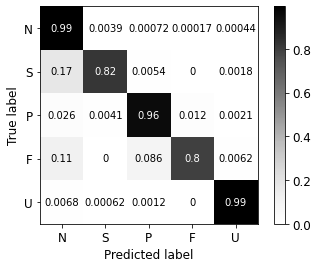

In [ ]:
cmm = confusion_matrix(y_true= out_test, y_pred=model_pred_test, labels=list(MIT_Outcome.keys()), normalize = 'true')
cm = confusion_matrix(y_true= out_test, y_pred=model_pred_test, labels=list(MIT_Outcome.keys()))
plt.figure(figsize=(12,30))

plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12) 
disp = ConfusionMatrixDisplay(confusion_matrix=cmm,display_labels=[MIT_Outcome[i] for i in MIT_Outcome],)
disp.plot(cmap = "Greys")

TruePositive = np.diag(cm)
FalsePositive = []
for i in range(len(MIT_Outcome)):
    FalsePositive.append(sum(cm[:,i]) - cm[i,i])
FalseNegative = []
for i in range(len(MIT_Outcome)):
    FalseNegative.append(sum(cm[i,:]) - cm[i,i])
TrueNegative = []
for i in range(len(MIT_Outcome)):
    temp = np.delete(cm, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))
#l = len(y)
#for i in range(len(MIT_Outcome)):
#    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)
print("True positive: ", TruePositive[i])
print("False positive: ", FalsePositive[i])
print("False negative: ", FalseNegative[i])
print("True negative: ", TrueNegative[i])

plt.savefig("confusion_matrix.png")
plt.show()

In [ ]:
a = {0:'(a)', 1: '(b)'}

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'f1_score']
  plt.figure(figsize= (12,20))
  plt.rc('font', size=10)          # controls default text sizes
  plt.rc('axes', titlesize=20)     # fontsize of the axes title
  plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
  plt.rc('legend', fontsize=20)    # legend fontsize
  plt.rc('figure', titlesize=20)  # fontsize of the figure title
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,1,n+1)
    plt.title(a[n])
    #plt.figure(figsize = (8,6))
    plt.plot(history.epoch, history.history[metric], label='Train ' + metric)
    plt.plot(history.epoch, history.history['val_'+ metric], linestyle="--", label='Val ' + metric)
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0.8,1])
    plt.legend()
  plt.savefig("Train_Loss.png")
  plt.show()

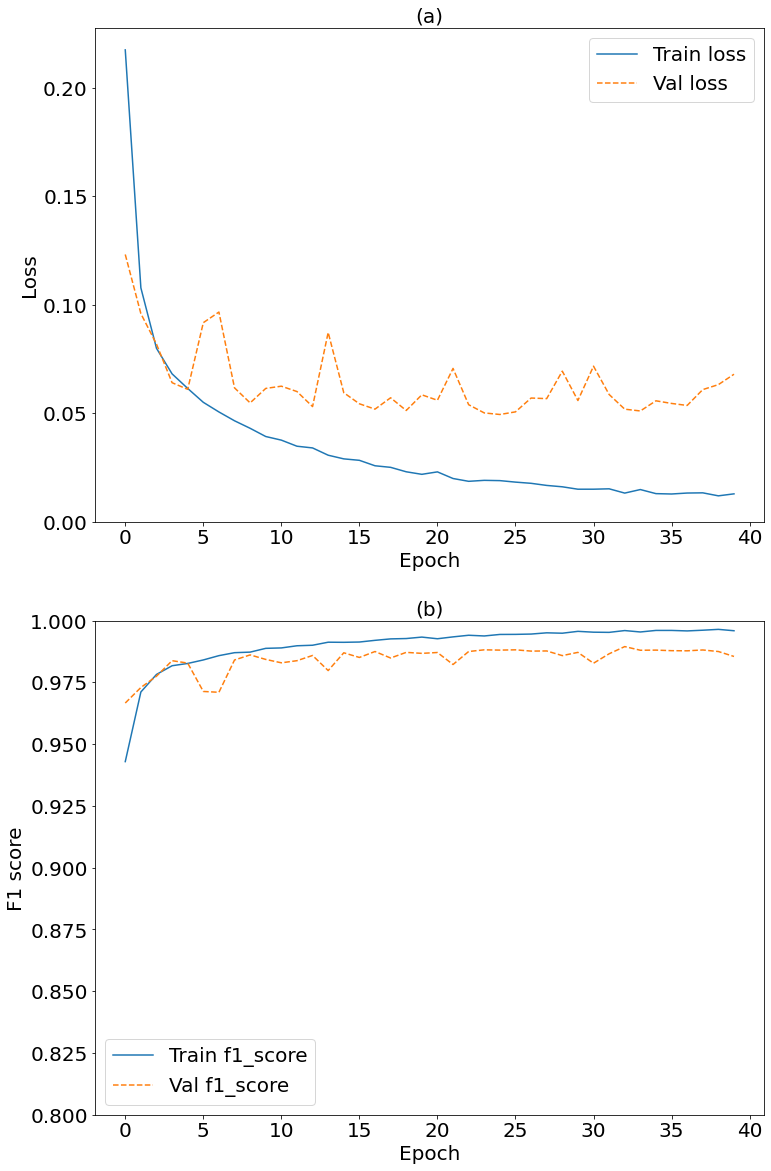

In [ ]:
plot_metrics(history_khanh)

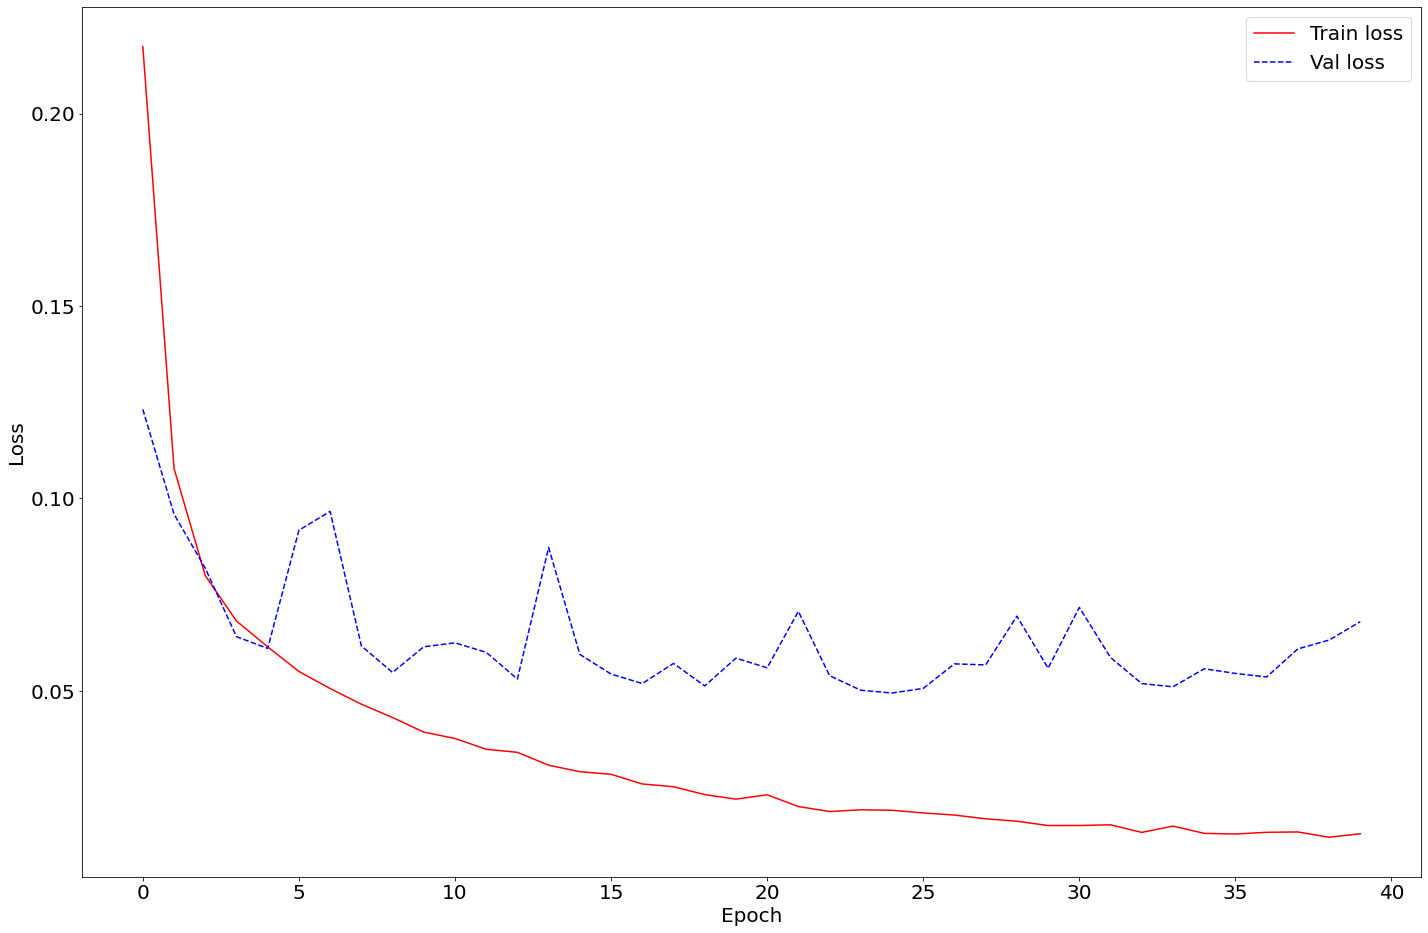

In [ ]:
plt.figure(figsize= (24,16))
plt.plot(history_khanh.epoch, history_khanh.history['loss'],
           color='r', label='Train loss')
plt.plot(history_khanh.epoch, history_khanh.history['val_loss'],
           color='b', label='Val loss' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Lost.png")
plt.show()

In [ ]:
import collections
count_predict = collections.Counter(model_pred_test)
model_y_test = np.argmax(y_test, axis = 1)
count_true = collections.Counter(model_y_test)
print(f"Predict = {count_predict}")
print(f"True = {count_true}")

Predict = Counter({0: 18185, 4: 1607, 2: 1416, 1: 535, 3: 149})
True = Counter({0: 18118, 4: 1608, 2: 1448, 1: 556, 3: 162})


In [2]:
diseases = ["Normal",
            "Supraventricular premature disease",
            "Premature ventricular disease",
            "Fusion of ventricular disease",
            "Unclassifiable disease"]
label = diseases[1]
print(label)

Supraventricular premature disease
